# IA for HumanForYou

## Membres du groupe
- Thibaut Meslin (Chef de projet)
- Gary Houivet
- Nathan Leroy
- Alaa Taleb

## Contexte
L'entreprise de produits pharmaceutiques HumanForYou basée en Inde emploie environ 4000 personnes. Cependant, chaque année elle subit un turn-over d'environ 15% de ses employés nécessitant de retrouver des profils similaires sur le marché de l'emploi.
La direction trouve que ce niveau de turn-over n'est pas bon pour l'entreprise car :
- Les projets sur lesquels étaient les employés quittant la société prennent du retard ce qui nuit à la réputation de l'entreprise auprès de ses clients et partenaires.
- Un service de ressources humaines de taille conséquente doit être conservé car il faut avoir les moyens de trouver les nouvelles recrues.
- Du temps est perdu à l'arrivée des nouveaux employés car ils doivent très souvent être formés et ont besoin de temps pour devenir pleinement opérationnels dans leur nouvel environnement.

## Données

Dans le cadre de ce projet, notre jeu de données est composé de 5 fichiers :
- general_data.csv
> Cette source de données fournie des données générales sur chaque employé.
Elle contient notamment pour chaque employé : son âge, son genre, son rôle dans l’entreprise, son salaire, etc… 
- manager_survey_data.csv
> La dernière évaluation de chaque employé par son manager.
  Son implication dans son travail ainsi que son niveau de performance annuel est évalué
- employee_survey_data.csv
> Enquête facultative sur la qualité de vie des employés mené en juin 2015.
  Chaque employé ayant participé à l’enquête a évalué : son environnement de travail, sa satisfaction au travail et son équilibre entre sa vie professionnelle et sa vie privée.
- in_time.csv et out_time.csv
> Horaires de travail relevé par la badgeuse dans les locaux de l’entreprise.


## Objectifs

L’objectif de ce projet est de déterminer les facteurs ayant le plus d’influence sur le taux de turn-over dans l’entreprise ainsi que d’apporter des pistes d’amélioration pour mettre fin à ce phénomène récurrent.

L’idée n’est pas de prévoir quels employés sont susceptibles de partir afin de ne plus recruter de candidats similaires dans le futur, ce qui ne serait pas éthique, mais bien de proposer des solutions pour donner envie aux employés susceptibles de partir de rester dans l’entreprise.

## Importation des bibliothèques


In [1]:
from numpy.random import default_rng # Random number generator

import numpy as np # Linear algebra
from statistics import mean # Mean calculation
import os # File management
import math # Math functions
import tqdm # Progress bar
from datetime import datetime # Date and time conversion
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
import pandas as pd # Data processing
from pandas.plotting import scatter_matrix # Scatter matrix

from sklearn.tree import DecisionTreeClassifier # Decision tree
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.linear_model import LogisticRegression # Logistic regression

from sklearn.model_selection import cross_val_score # Cross validation
from sklearn.metrics import mean_squared_error # Mean squared error
from sklearn.metrics import confusion_matrix # Confusion matrix
from sklearn.metrics import f1_score # F1 score

from sklearn.model_selection import StratifiedShuffleSplit # Stratified split

import warnings # ignorer les warnings inutiles (voir SciPy issue #5998)
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
PROJECT_ROOT_DIR = "." # Dossier du projet
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images") # Dossier de sauvegarde des figures
DATASET_PATH = os.path.join(PROJECT_ROOT_DIR, "dataset") # Dossier avec les données d'entrées

In [3]:
random_state = 42 # Graine de génération aléatoire afin de pouvoir reproduire les résultats à chaque exécution du juptyer notebook

# Data wrangling

### Import des données

In [4]:
def load_data(file, dataset_path=DATASET_PATH):
    csv_path = os.path.join(dataset_path, file)
    return pd.read_csv(csv_path)

#Import des données
general_data = load_data("general_data.csv")
manager_survey_data = load_data("manager_survey_data.csv")
employee_survey_data = load_data("employee_survey_data.csv")
in_time_data = load_data("in_time.csv")
out_time_data = load_data("out_time.csv")

### Verification du dataset

On va dans un premier temps vérifier si le dataset est complet et s'il n'y a pas de valeurs manquantes. On va également vérifier si les données sont cohérentes et si elles sont dans le bon format (numériques) pour pouvoir les traiter.

In [5]:
def check_missing_values(file, name):

    temp_df = pd.DataFrame(file, file.index, file.columns)

    na_count = temp_df.isna().sum().sum()
    empty_count = temp_df.iloc[:, :].eq('').sum().sum()
    total_count = temp_df.count().sum()

    print("Le dataset", name, "contient", total_count, "données")
    print("Valeurs N/A:", na_count, "soit", round(na_count*100/total_count, 3), "% du dataset")
    print("Valeurs nulles:", empty_count, "soit", round(empty_count*100/total_count, 3), "% du dataset \n")

In [6]:
check_missing_values(general_data, "general_data")
check_missing_values(manager_survey_data, "manager_survey_data")
check_missing_values(employee_survey_data, "employee_survey_data")
check_missing_values(in_time_data, "in_time_data")
check_missing_values(out_time_data, "out_time_data")

Le dataset general_data contient 105812 données
Valeurs N/A: 28 soit 0.026 % du dataset
Valeurs nulles: 0 soit 0.0 % du dataset 

Le dataset manager_survey_data contient 13230 données
Valeurs N/A: 0 soit 0.0 % du dataset
Valeurs nulles: 0 soit 0.0 % du dataset 

Le dataset employee_survey_data contient 17557 données
Valeurs N/A: 83 soit 0.473 % du dataset
Valeurs nulles: 0 soit 0.0 % du dataset 

Le dataset in_time_data contient 1046340 données
Valeurs N/A: 109080 soit 10.425 % du dataset
Valeurs nulles: 0 soit 0.0 % du dataset 

Le dataset out_time_data contient 1046340 données
Valeurs N/A: 109080 soit 10.425 % du dataset
Valeurs nulles: 0 soit 0.0 % du dataset 



On remarque que les fichiers *"general_data.csv"*, *"employee_survey_data.csv"*, *"in_time_data.csv"* et *"out_time_data.csv"* possèdent des valeurs manquantes. On va donc devoir traiter ces valeurs afin de rendre le dataset complet et exploitable par la suite. 
Les données manquantes sont sur les colones suivantes :
- *NumCompaniesWorked* & *TotalWorkingYears* --> **28 trous**
- *EnvironmentSatisfaction* & *JobSatisfaction* & *WorkLifeBalance* --> **83 trous**
- Trous correspondant à des absences de badgeage --> **218160 trous au total**

In [7]:
general_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

Certaines colonnes ne sont pas pertinentes pour notre étude comme la colonne *"Over18"* qui ne nous servira pas et dont on peut facilement se passer en regardant les données dans la colonne *"Age"*, ces colonnes seront donc supprimées.

Néanmoins, nous avons fait le choix de garder les colonnes *"Attrition"* et *"Department"* car elles représentent des valeurs importantes pour notre étude. Nous allons donc devoir convertir ces colonnes en données numériques afin de pouvoir les traiter, de même pour la colonne *"BusinessTravel"*.

### Transformation du dataset

Dans un premier temps, nous allons créé de la valeur à partir des fichiers *"in_time_data.csv"* et *"out_time_data.csv"* en calculant le temps de travail de chaque employé. Nous serons donc en mesure de calculer son temps de travail moyen sur toute la période fournie dans le dataset. Cette moyenne sera enregistrée dans une nouvelle colonne *"AverageWorkTime"*.

In [8]:
def mean_work_time():
    daily_work_time = []
    total_work_avg = []
    for user in tqdm.tqdm(range(0, len(in_time_data))): # Pour chaque utilisateur
        for data in range(1, len(in_time_data.columns)): # Pour chaque jour
            if (pd.isna(out_time_data.iloc[user, data])) or (pd.isna(in_time_data.iloc[user, data])): #Si l'employé n'était pas présent ce jour là
                continue
            else:
                daily_work_time.append(
                    (datetime.strptime(out_time_data.iloc[user, data], '%Y-%m-%d %H:%M:%S') - datetime.strptime(in_time_data.iloc[user, data], '%Y-%m-%d %H:%M:%S')).total_seconds() / 3600 # On calcule le temps travaillé en heures et on l'ajoute au tableau
                )
        total_work_avg.append(round(mean(daily_work_time), 2)) # On fait la moyenne des heures travaillés et on l'arrondie à 2 chiffres après la virgule
        daily_work_time.clear() # On vide le tableau pour le prochain employé
    in_time_data["MeanWorkTime"] = total_work_avg # On ajoute le résultat dans le dataframe

mean_work_time()
in_time_data["MeanWorkTime"]

100%|██████████| 4410/4410 [02:20<00:00, 31.49it/s]


0       7.37
1       7.72
2       7.01
3       7.19
4       8.01
        ... 
4405    8.52
4406    6.09
4407    7.71
4408    9.49
4409    6.99
Name: MeanWorkTime, Length: 4410, dtype: float64

In [9]:
# Suppression des jours non travaillés du jeu de données horaires (Weekends et jours fériés)
def remove_holidays():
    in_time_data.dropna(axis=1, how='all', inplace=True)

print("Nombre de colonnes avant suppression des jours fériés:", in_time_data.shape[1], "--> NA totaux :", in_time_data.isna().sum().sum())
remove_holidays()
print("Nombre de colonnes après suppression des jours fériés:", in_time_data.shape[1], "--> NA restant :", in_time_data.isna().sum().sum())

# Compter le nombre de "N/A" dans chaque ligne et l'ajouter comme nouvelle colonne "N/A_count"
in_time_data["AbsentCount"] = in_time_data.isna().sum(axis=1)
in_time_data["AbsentCount"]

Nombre de colonnes avant suppression des jours fériés: 263 --> NA totaux : 109080
Nombre de colonnes après suppression des jours fériés: 251 --> NA restant : 56160


0       17
1       13
2        7
3       14
4        4
        ..
4405     6
4406     8
4407    18
4408     8
4409    17
Name: AbsentCount, Length: 4410, dtype: int64

In [10]:
# Remplacer les catégories par des valeurs numériques
general_data['Attrition'] = general_data['Attrition'].replace({'No': 0, 'Yes': 1})
general_data['BusinessTravel'] = general_data['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
general_data['Department'] = general_data['Department'].replace({'Human Resources': 0, 'Research & Development': 1, 'Sales': 2})

# Affichage des  dataframes transformés
general_data[['Attrition', 'BusinessTravel', 'Department']]


,Attrition,BusinessTravel,Department
0,0,1,2
1,1,2,1
2,0,2,1
3,0,0,1
4,0,1,1
...,...,...,...
4405,0,1,1
4406,0,1,1
4407,0,1,1
4408,0,1,2


On renomme la première colonne *"Unnamed: 0"* en *"EmployeeID"* pour plus de permettre une meilleure compréhension du dataset et pour pouvoir l'utiliser comme index lors d'une fusion de dataset.

In [11]:
def rename_column(dataset, name, position):
    tbl = dataset.columns.tolist()
    tbl[position] = name
    dataset.columns = tbl

print(in_time_data.columns[0])

rename_column(in_time_data, "EmployeeID", 0)

print(in_time_data.columns[0])

Unnamed: 0
EmployeeID


On supprime les lignes contenant des valeurs manquantes dans le dataset *"general_data.csv"* car il n'y a que 28 trous et que ces lignes ne sont pas représentatives de l'ensemble du dataset. On les supprime donc pour avoir un dataset correct et exploitable.

In [12]:
general_data.dropna(axis=0, how='any', inplace=True)

On remplace toutes les valeurs manquantes par la moyenne des valeurs de la colonne correspondante élevée au supérieur.

In [13]:
employee_survey_data['EnvironmentSatisfaction'].fillna(math.ceil(employee_survey_data['EnvironmentSatisfaction'].mean()), inplace=True)
employee_survey_data['JobSatisfaction'].fillna(math.ceil(employee_survey_data['JobSatisfaction'].mean()), inplace=True)
employee_survey_data['WorkLifeBalance'].fillna(math.ceil(employee_survey_data['WorkLifeBalance'].mean()), inplace=True)

On va maintenant créer un dataset global qui contiendra toutes les informations nécessaires à notre étude. On va donc fusionner les différents fichiers en fonction de l'identifiant de l'employé.

In [14]:
global_dataset = pd.merge(general_data, manager_survey_data, on='EmployeeID')
global_dataset = pd.merge(global_dataset, employee_survey_data, on='EmployeeID')
global_dataset = pd.merge(global_dataset, in_time_data[["MeanWorkTime", "AbsentCount", "EmployeeID"]], on='EmployeeID')

On supprime les colonnes que nous avons jugées inutiles ou non-éthiques pour notre étude.

In [15]:
columns_to_drop = ["EducationField", "EmployeeCount", "EmployeeID", "Gender", "JobRole", "MaritalStatus", "Over18"]
global_dataset.drop(columns_to_drop, axis=1, inplace=True)
global_dataset.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'JobInvolvement',
       'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'MeanWorkTime', 'AbsentCount'],
      dtype='object')

# Visualisation du jeu d'étude

A partir de là, nous avons notre jeu final d'étude : **global_dataset**

Dans cette étape, nous allons vérifier post-fusion, si nos données sont bien complètes et bien typés et commencer à rechercher des pistes de solutions pour le problème de turn-over.

In [16]:
check_missing_values(global_dataset, "global_dataset")

Le dataset global_dataset contient 105168 données
Valeurs N/A: 0 soit 0.0 % du dataset
Valeurs nulles: 0 soit 0.0 % du dataset 



In [17]:
global_dataset.dtypes

Age                          int64
Attrition                    int64
BusinessTravel               int64
Department                   int64
DistanceFromHome             int64
Education                    int64
JobLevel                     int64
MonthlyIncome                int64
NumCompaniesWorked         float64
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
JobInvolvement               int64
PerformanceRating            int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
MeanWorkTime               float64
AbsentCount                  int64
dtype: object

Premier apperçu des données :

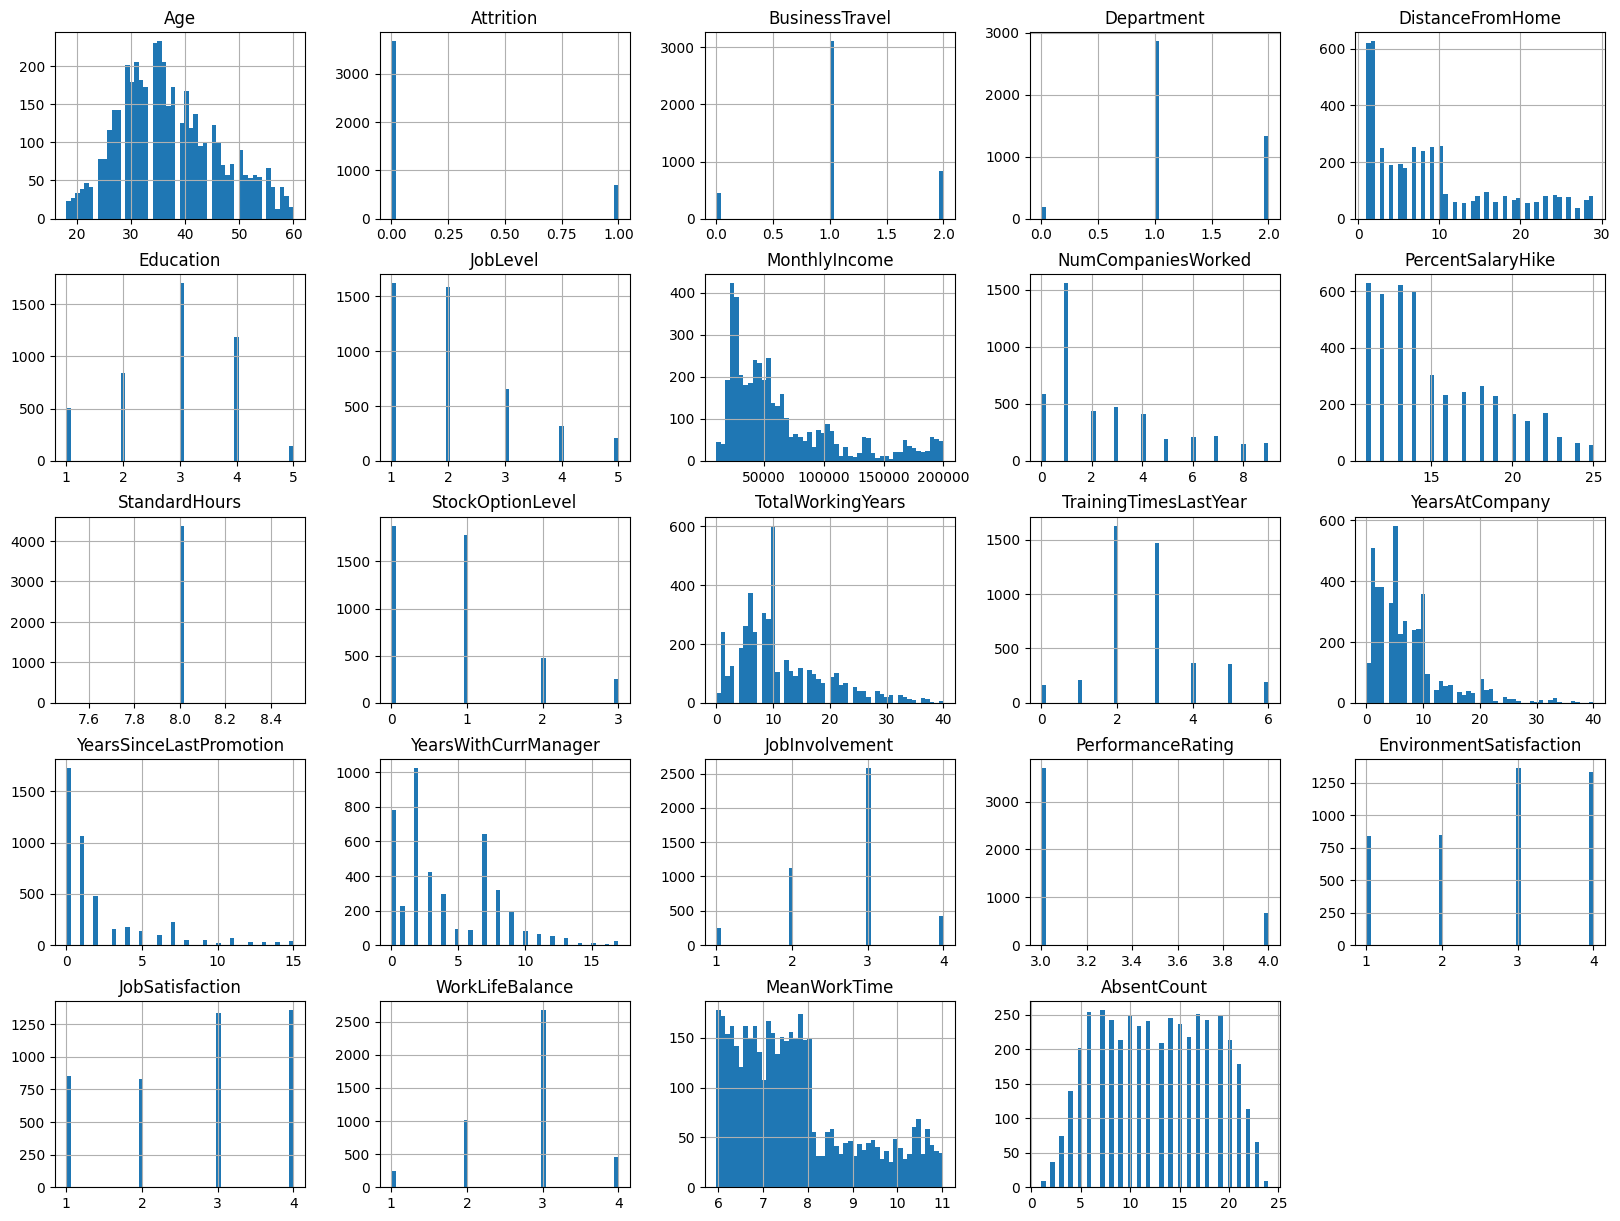

In [18]:
global_dataset.hist(bins=50, figsize=(20,15))
plt.show()

Nous avons donc un taux de turnover de 16.09 %.


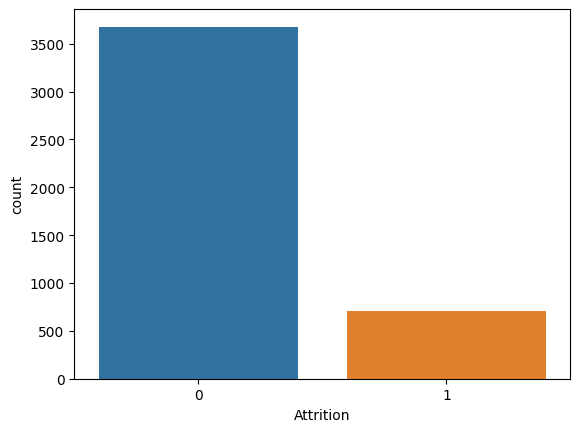

<Axes: xlabel='Attrition', ylabel='Age'>

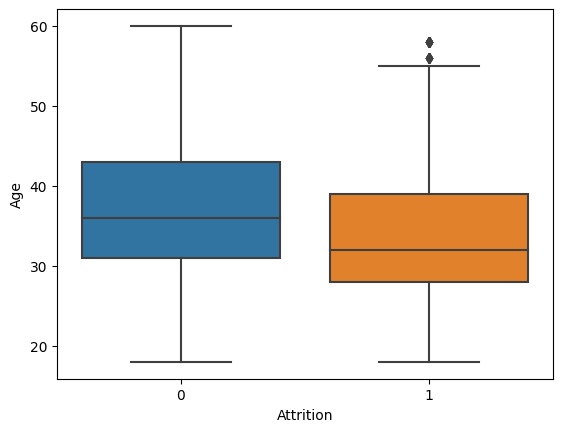

In [19]:
percentage = ((general_data['Attrition'] == 1).sum() / general_data['Attrition'].shape[0]) * 100

print("Nous avons donc un taux de turnover de", round(percentage, 2), "%.")

sns.countplot(x='Attrition', data=general_data)
plt.show()
sns.boxplot(x='Attrition', y='Age', data=general_data)

On peut voir grace à cette boite à moustache que ce sont principalement des employés plus jeunes qui quittent l'entreprise.

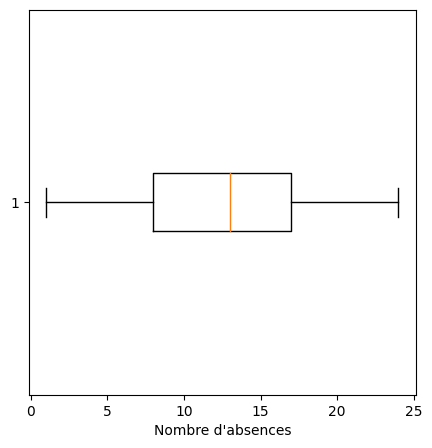

In [20]:
plt.figure(figsize=(5, 5))
plt.boxplot(global_dataset['AbsentCount'], vert=False)
plt.xlabel('Nombre d\'absences')
plt.show()

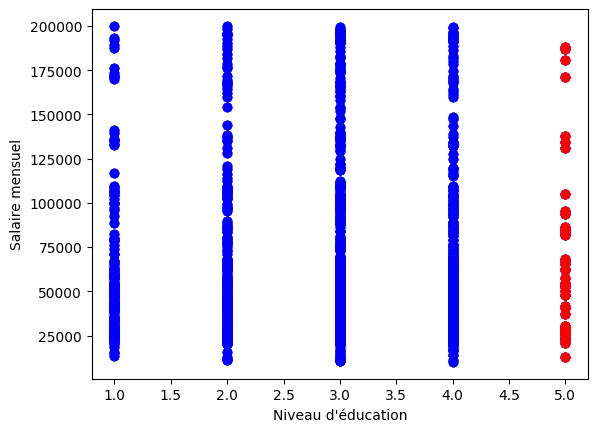

In [21]:
# Tracer le graphe de relation entre le salaire moyen et le niveau d'éducation
plt.scatter(general_data['Education'], general_data['MonthlyIncome'], c='blue')
plt.scatter(general_data[general_data['Education'] == 5]['Education'], general_data[general_data['Education'] == 5]['MonthlyIncome'], c='red')
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Salaire mensuel')
plt.show()

On peut remarquer que les employés ayant un très haut niveau d'éducation ont un salaire relativement bas par rapport aux niveau 2, 3 et 4. C'est donc un point à prendre compte. Certains employés hautement qualifiés pourraient être tentés de quitter l'entreprise pour trouver un poste plus rémunérateur.

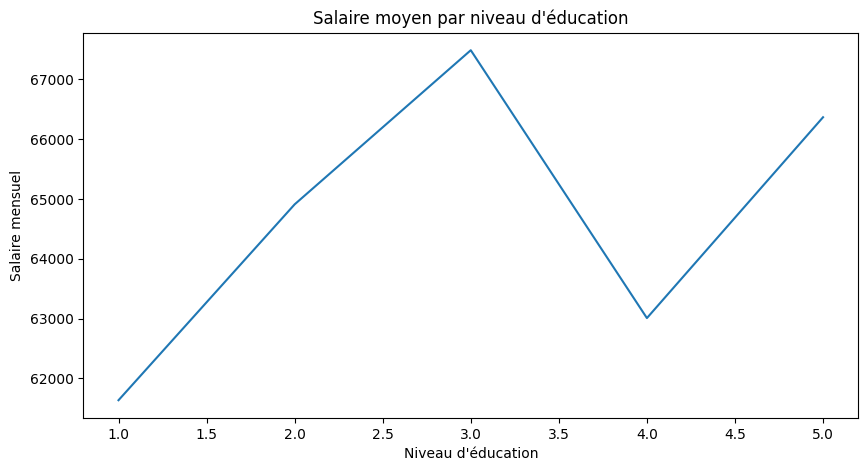

In [22]:
salaire_moyen = general_data.groupby('Education')['MonthlyIncome'].mean()
salaire_moyen.plot(title='Salaire moyen par niveau d\'éducation', figsize=(10, 5))
plt.xlabel('Niveau d\'éducation')
plt.ylabel('Salaire mensuel')
plt.show()

On remarque aussi que la catégorie d'employés ayant un niveau d'éducation de 3, ont le salaire moyen le plus élevé. Il devrait logiquement être plus élevé pour les employés ayant un niveau d'éducation de 4 ou 5.

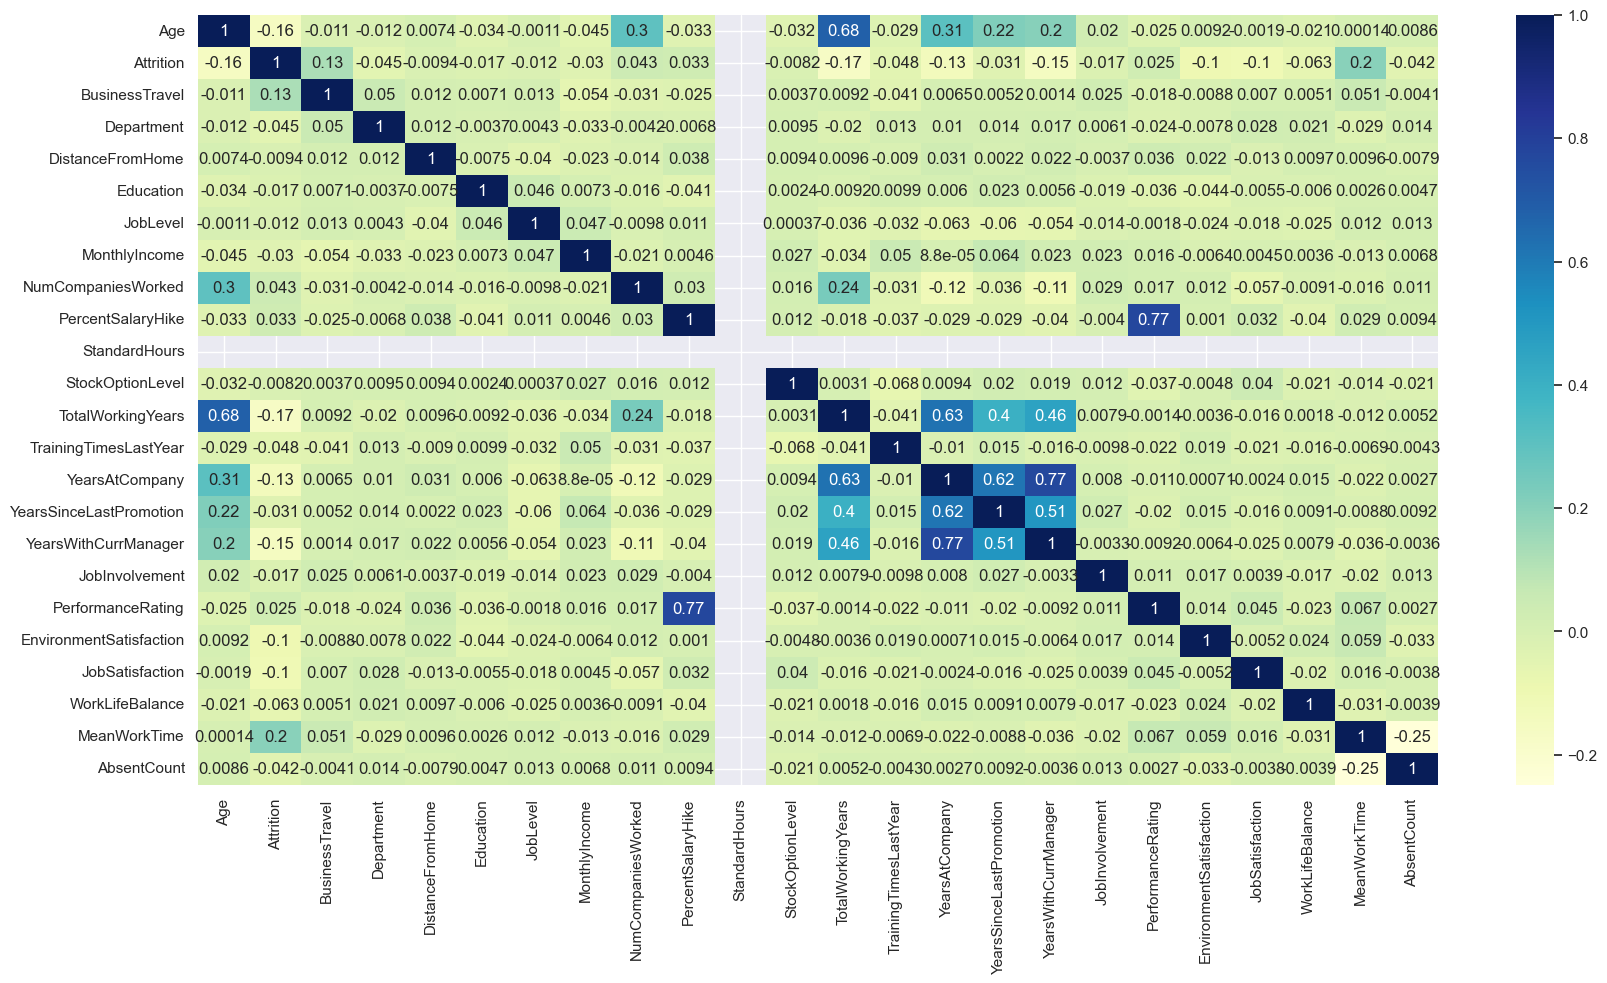

In [23]:
# Visualisation d'une heatmap (carte de chaleur) des paramètres pour voir les corrélations
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(global_dataset.corr(), cmap="YlGnBu", annot = True)
plt.show()

# Modélisation

On créé un jeu de données d'entrainement et un jeu de données de test avec un ratio 80/20. On va ensuite tester plusieurs modèles différents pour voir lequel donne les meilleurs résultats.

In [24]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)

for train_index, test_index in split.split(global_dataset, global_dataset["Attrition"]):
    stratified_train_set = global_dataset.loc[train_index]
    stratified_test_set = global_dataset.loc[test_index]

train_labels = stratified_train_set["Attrition"].copy()
test_labels = stratified_test_set["Attrition"].copy()

In [25]:
for set_ in (stratified_train_set, stratified_test_set):
    set_.drop("Attrition", axis=1, inplace=True)

train_set_prepared = stratified_train_set.copy()

stratified_test_set.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MeanWorkTime,AbsentCount
3776,34,1,1,2,2,2,65860,9.0,18,8,...,2,2,1,3,3,2.0,4.0,2.0,6.11,8
1891,37,1,2,10,4,3,30720,5.0,14,8,...,14,11,7,2,3,1.0,3.0,1.0,6.28,22
2848,40,1,1,11,3,2,70050,1.0,20,8,...,20,9,9,3,4,4.0,3.0,3.0,6.22,19
674,30,1,2,9,1,4,40890,0.0,18,8,...,9,6,7,4,3,1.0,4.0,3.0,6.23,12
2063,28,1,1,6,3,2,23510,1.0,16,8,...,6,3,3,3,3,4.0,1.0,3.0,7.16,10


##### Préparation

In [26]:
def model_rmse(model, dataset, labels):
    predictions = model.predict(dataset)
    mse = mean_squared_error(labels, predictions)
    return np.sqrt(mse)

In [27]:
def cross_val_score_rmse(model, dataset, labels):
    scores = cross_val_score(model, dataset, labels, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores

In [28]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", round(scores.std(), 4) * 100, "%")

In [29]:
def train_rating(model, dataset, labels):
    cf_matrix = confusion_matrix(labels, model.predict(dataset))

    # Confusion matrix heatmap
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.show()

    #Learnin curve
    from sklearn.model_selection import learning_curve
    train_sizes, train_scores, test_scores = learning_curve(model, dataset, labels, cv=10, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

    #Show learning curve
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.ylabel('F1 score')
    plt.xlabel('Training set size')
    plt.title('Learning curve')
    plt.legend(loc='best')
    plt.show()

def model_rating(model, dataset, labels):
    cf_matrix = confusion_matrix(labels, model.predict(dataset))

    # Confusion matrix heatmap
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.show()

### Modèle 1 : Arbre de décision

In [30]:
tree_reg = DecisionTreeClassifier(random_state=random_state)
tree_reg.fit(train_set_prepared, train_labels)
print("Score du modèle Arbre de décision :", round(tree_reg.score(train_set_prepared, train_labels), 3) * 100, "%")

Score du modèle Arbre de décision : 100.0 %


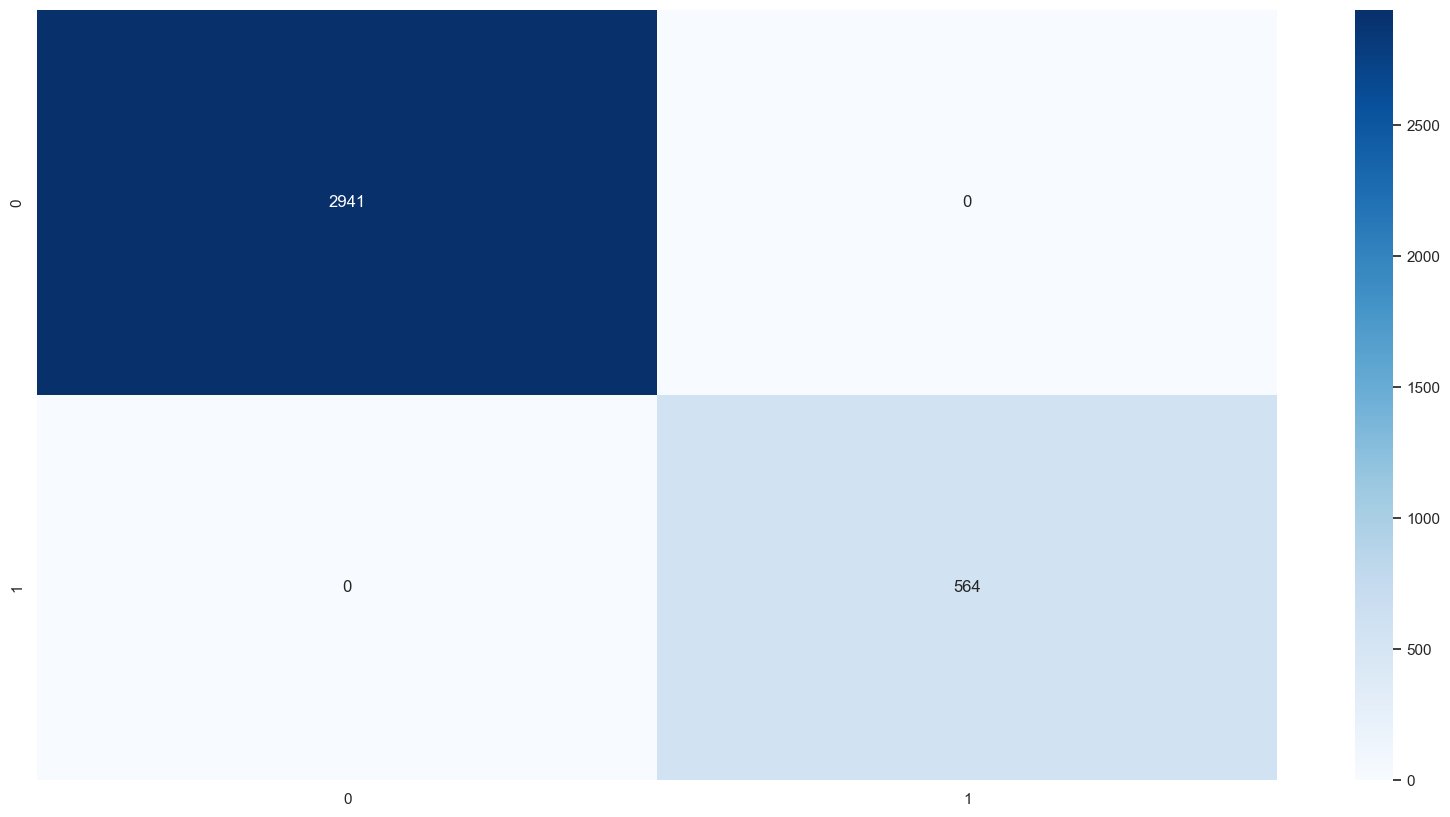

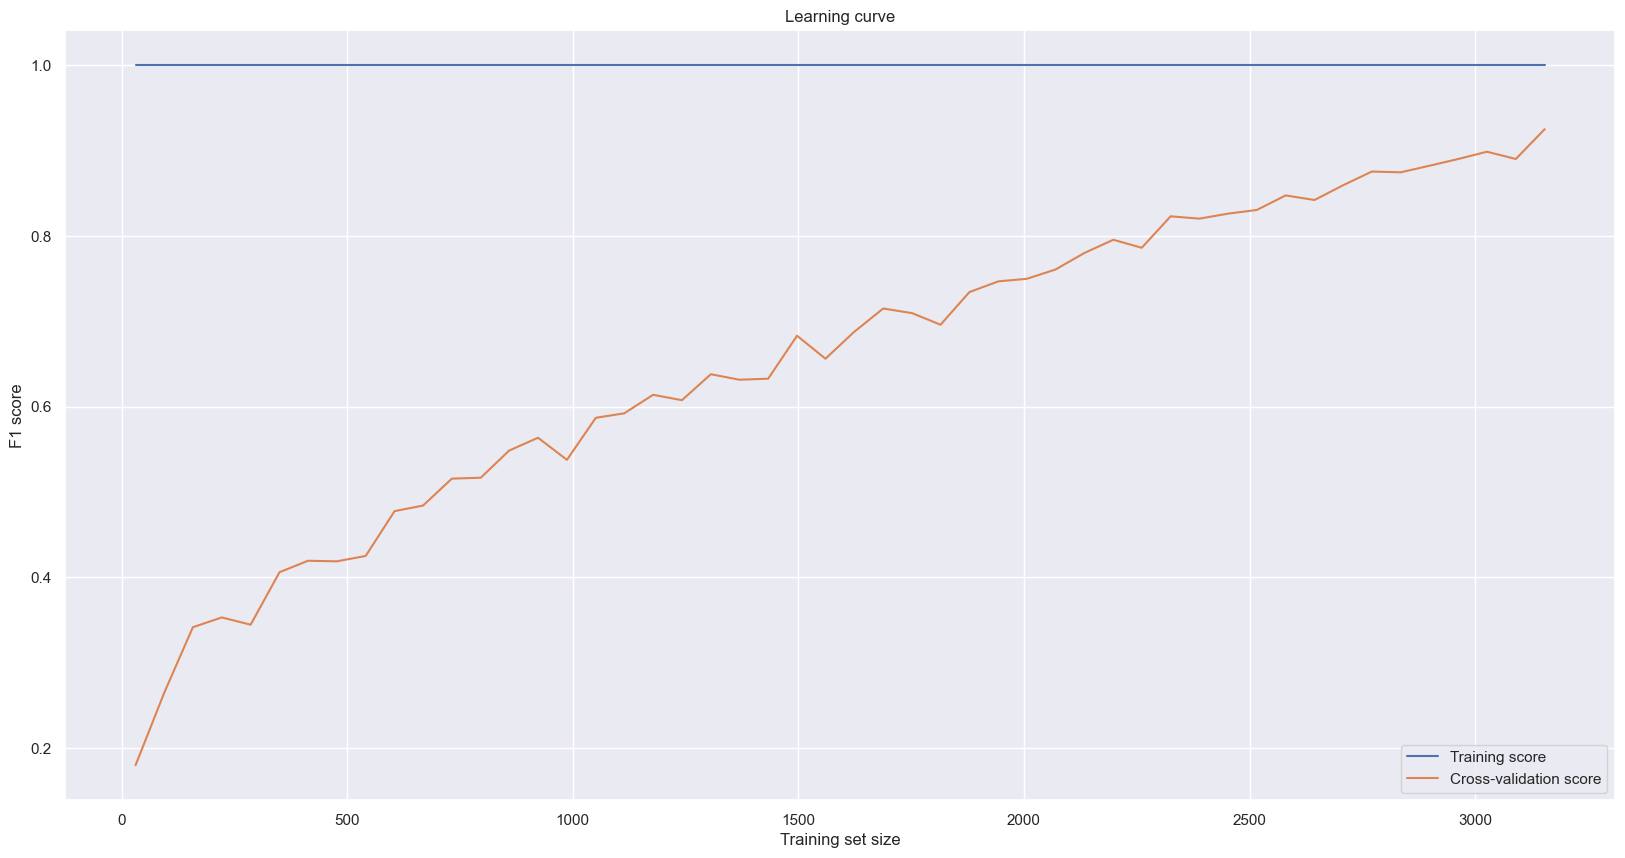

In [31]:
train_rating(tree_reg, train_set_prepared, train_labels)

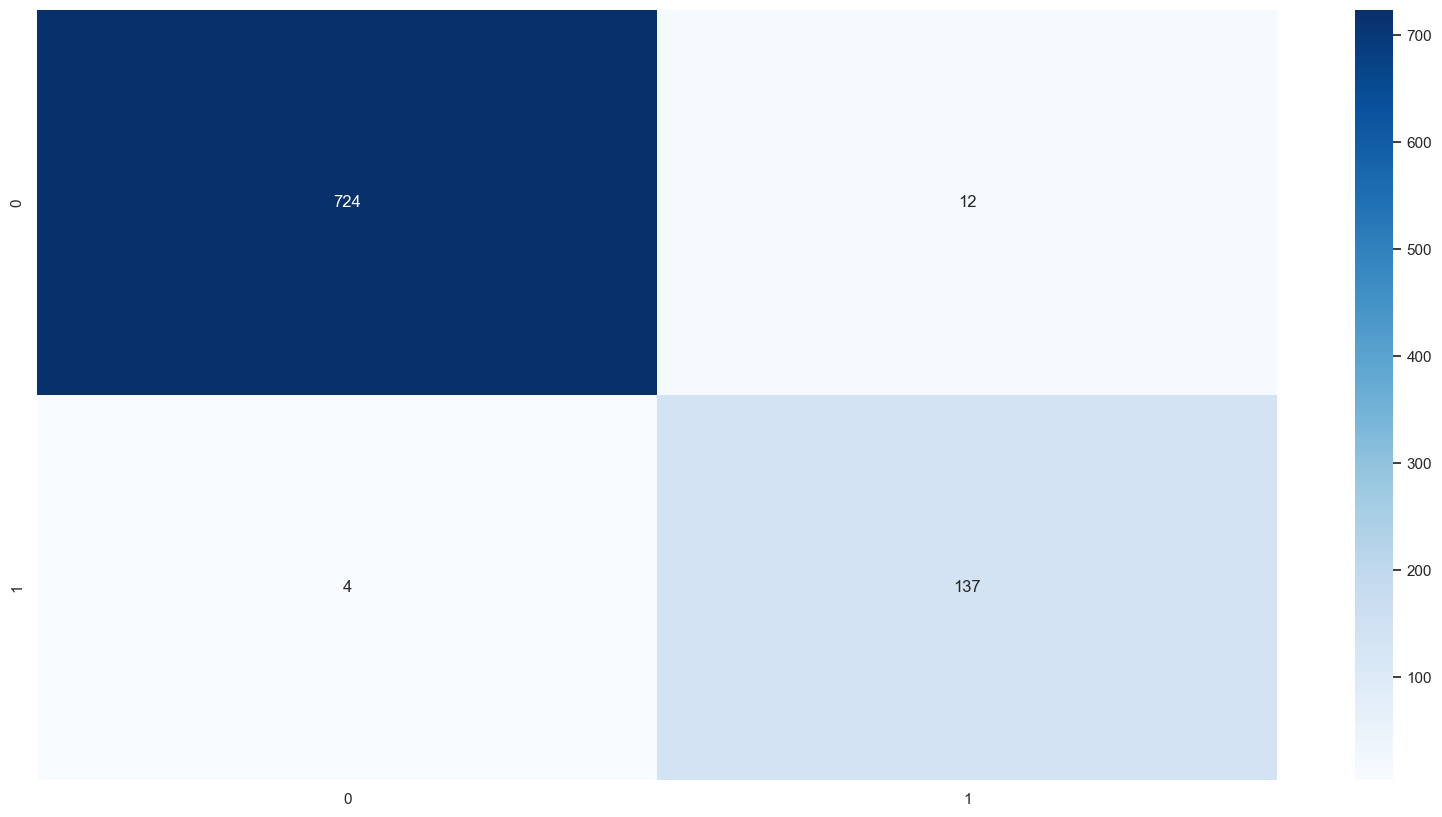

In [32]:
model_rating(tree_reg, stratified_test_set, test_labels)

In [33]:
tree_reg.predict(stratified_test_set)

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

On évalue ensuite ces prédictions par rapport aux vraies valeurs. Cela nous permettra d'évaluer notre modèle.

In [34]:
tree_reg.score(stratified_test_set, test_labels)

0.9817559863169898

### Modèle 2 : Random Forest

In [35]:
forest_reg = RandomForestClassifier(n_estimators=51, max_features=6, random_state=random_state)
forest_reg.fit(train_set_prepared, train_labels)
print("Score du modèle Random Forest :", round(forest_reg.score(train_set_prepared, train_labels), 3) * 100, "%")

Score du modèle Random Forest : 100.0 %


In [36]:
forest_reg.predict(stratified_test_set)

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [37]:
forest_reg.score(stratified_test_set, test_labels)

0.9874572405929305

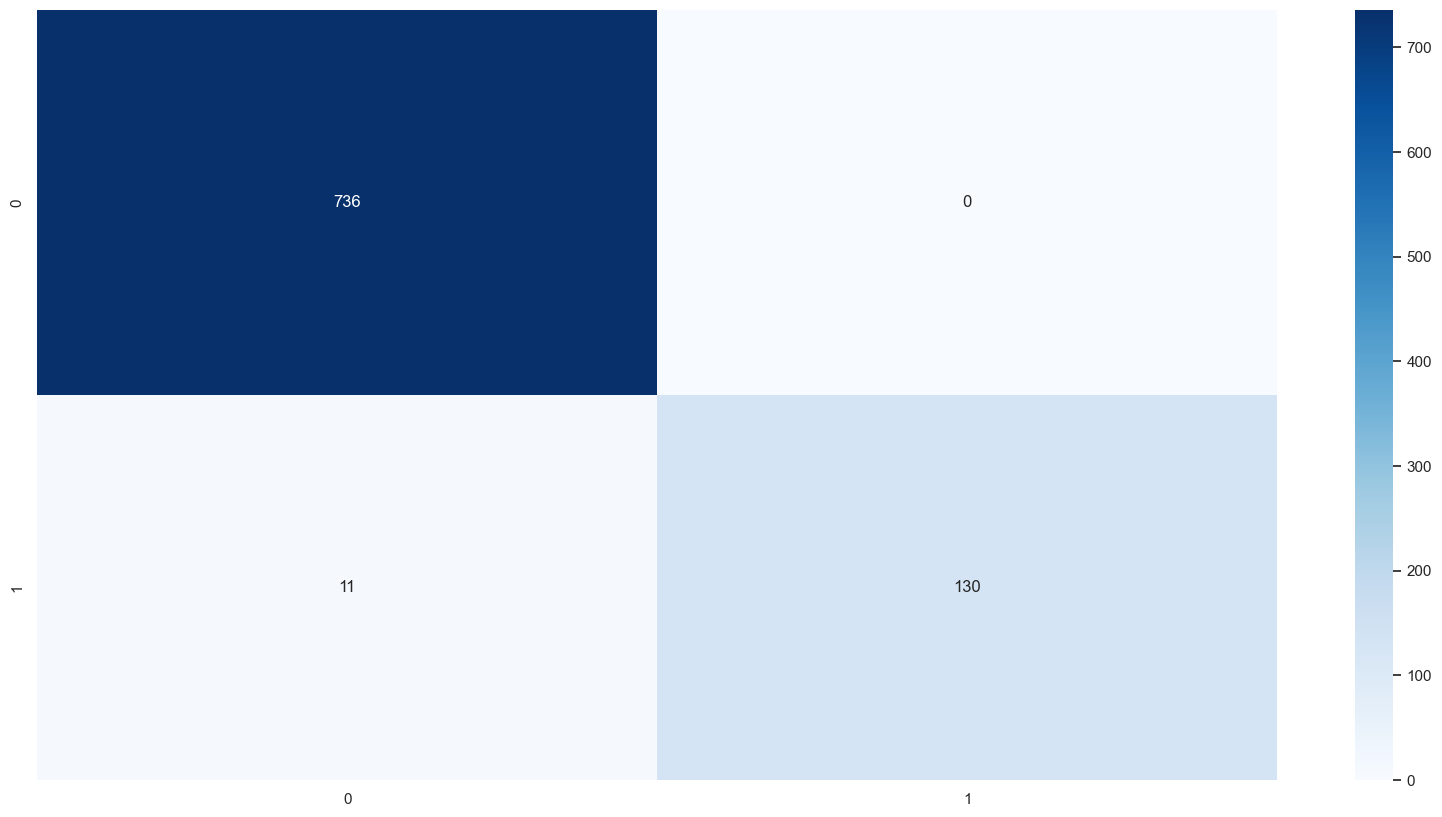

In [38]:
model_rating(forest_reg, stratified_test_set, test_labels)

Cette matrice de confusion est prometeuse !

Le recall est parfait et la precision est plus qu'acceptable.

### Modèle 3 : Régression logistique

In [39]:
logistic_reg = LogisticRegression(max_iter=3000)
logistic_reg.fit(train_set_prepared, train_labels)
logistic_reg.score(train_set_prepared, train_labels)

0.8390870185449358

In [40]:
model_rmse(logistic_reg, train_set_prepared, train_labels)

0.40113960344880456

In [41]:
logistic_reg_rmse_scores = cross_val_score_rmse(logistic_reg, train_set_prepared, train_labels)

In [42]:
display_scores(logistic_reg_rmse_scores)

Scores: [0.39223227 0.40298035 0.40298035 0.40298035 0.40298035 0.4
 0.38544964 0.38544964 0.4        0.3927922 ]
Mean: 0.39678451615673366
Standard deviation: 0.6799999999999999 %


In [43]:
logistic_reg.predict(stratified_test_set)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [44]:
model_rmse(logistic_reg, stratified_test_set, test_labels)

0.4009680418456413

In [45]:
logistic_reg.score(stratified_test_set, test_labels)

0.8392246294184721

Comme nous pouvons le voir, ce dernier modèle n'a pas l'air adapté à notre problème au vue de ses prédictions.

Il n'est pas capable de prédire les employés qui vont partir de l'entreprise car ne fournit en réponse que des prédictions égales à 0.

Nous decidons de garder le modèle de Random Forest car il a un meilleur score que les autres modèles.
Nous allons chercher à améliorer ce score en utilisant la méthode RandomSearchCV.

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


param_distribs = {
        'n_estimators': randint(low=1, high=100),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=25, cv=5, scoring='f1', random_state=42, n_jobs=-1).fit(stratified_train_set, train_labels)

rnd_search.best_params_

rnd_search.best_estimator_

RandomForestClassifier(max_features=6, n_estimators=51, random_state=42)

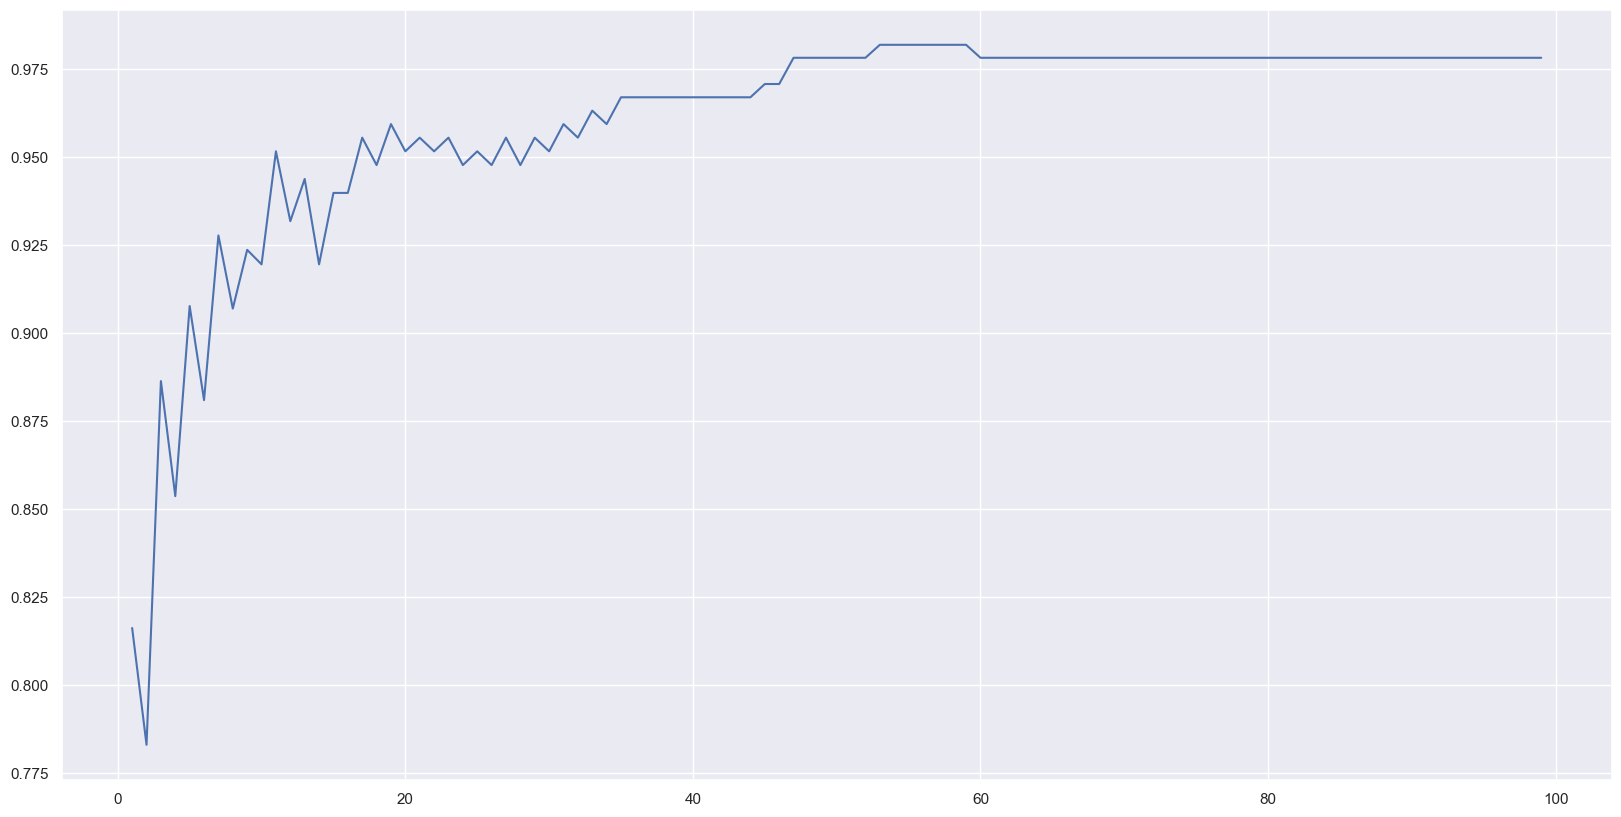

In [53]:
#Find best number of estimators to maximaze F1 score
from sklearn.metrics import f1_score

f1_scores = []
for i in range(1, 100):
    forest_reg = RandomForestClassifier(n_estimators=i, random_state=random_state).fit(train_set_prepared, train_labels)
    f1_scores.append(f1_score(test_labels, forest_reg.predict(stratified_test_set)))

plt.plot(range(1, 100), f1_scores)
plt.show()

TESTS en tout genre

In [49]:
global_dataset.describe()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,MeanWorkTime,AbsentCount
count,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,...,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000,4382.000000
mean,36.933364,0.160885,1.086034,1.260840,9.198996,2.912369,2.063898,65061.702419,2.693291,15.210634,...,7.010497,2.191693,4.126198,2.730488,3.154039,2.725011,2.729347,2.763122,7.700598,12.727978
std,9.137272,0.367467,0.532137,0.527461,8.105396,1.024728,1.106115,47142.310175,2.497832,3.663007,...,6.129351,3.224994,3.569674,0.710682,0.361028,1.090479,1.099377,0.704458,1.341284,5.497935
min,18.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,10090.000000,0.000000,11.000000,...,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1.000000,5.950000,1.000000
25%,30.000000,0.000000,1.000000,1.000000,2.000000,2.000000,1.000000,29110.000000,1.000000,12.000000,...,3.000000,0.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,6.670000,8.000000
50%,36.000000,0.000000,1.000000,1.000000,7.000000,3.000000,2.000000,49190.000000,2.000000,14.000000,...,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,7.410000,13.000000
75%,43.000000,0.000000,1.000000,2.000000,14.000000,4.000000,3.000000,83790.000000,4.000000,18.000000,...,9.000000,3.000000,7.000000,3.000000,3.000000,4.000000,4.000000,3.000000,8.367500,17.000000
max,60.000000,1.000000,2.000000,2.000000,29.000000,5.000000,5.000000,199990.000000,9.000000,25.000000,...,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000,11.030000,24.000000


In [50]:
corr_matrix = global_dataset.corr()
corr_matrix["Attrition"].sort_values(ascending=False)

Attrition                  1.000000
MeanWorkTime               0.198916
BusinessTravel             0.125306
NumCompaniesWorked         0.042831
PercentSalaryHike          0.033153
PerformanceRating          0.024780
StockOptionLevel          -0.008164
DistanceFromHome          -0.009449
JobLevel                  -0.012382
JobInvolvement            -0.016602
Education                 -0.017106
MonthlyIncome             -0.030160
YearsSinceLastPromotion   -0.031423
AbsentCount               -0.041942
Department                -0.044624
TrainingTimesLastYear     -0.047586
WorkLifeBalance           -0.063488
EnvironmentSatisfaction   -0.100900
JobSatisfaction           -0.102940
YearsAtCompany            -0.133003
YearsWithCurrManager      -0.154692
Age                       -0.158399
TotalWorkingYears         -0.169670
StandardHours                   NaN
Name: Attrition, dtype: float64

array([[<Axes: xlabel='Attrition', ylabel='Attrition'>,
        <Axes: xlabel='MonthlyIncome', ylabel='Attrition'>,
        <Axes: xlabel='TotalWorkingYears', ylabel='Attrition'>,
        <Axes: xlabel='YearsAtCompany', ylabel='Attrition'>,
        <Axes: xlabel='YearsSinceLastPromotion', ylabel='Attrition'>,
        <Axes: xlabel='YearsWithCurrManager', ylabel='Attrition'>],
       [<Axes: xlabel='Attrition', ylabel='MonthlyIncome'>,
        <Axes: xlabel='MonthlyIncome', ylabel='MonthlyIncome'>,
        <Axes: xlabel='TotalWorkingYears', ylabel='MonthlyIncome'>,
        <Axes: xlabel='YearsAtCompany', ylabel='MonthlyIncome'>,
        <Axes: xlabel='YearsSinceLastPromotion', ylabel='MonthlyIncome'>,
        <Axes: xlabel='YearsWithCurrManager', ylabel='MonthlyIncome'>],
       [<Axes: xlabel='Attrition', ylabel='TotalWorkingYears'>,
        <Axes: xlabel='MonthlyIncome', ylabel='TotalWorkingYears'>,
        <Axes: xlabel='TotalWorkingYears', ylabel='TotalWorkingYears'>,
        <Axes:

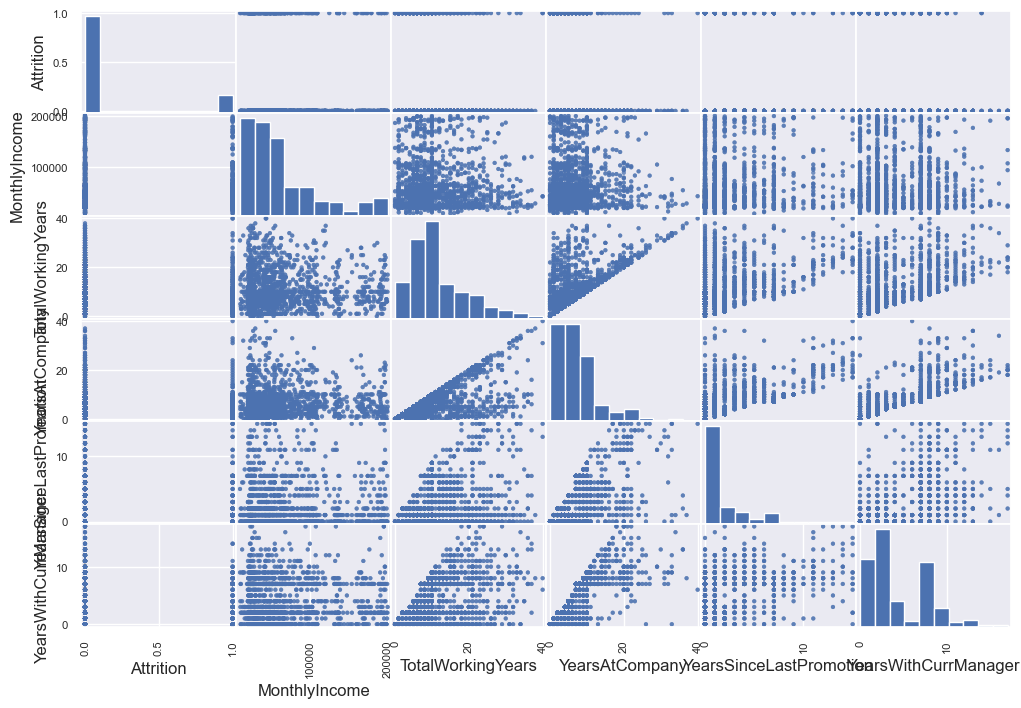

In [51]:
scatter_matrix(global_dataset[["Attrition", "MonthlyIncome", "TotalWorkingYears", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager"]], figsize=(12, 8))

In [52]:
for name in global_dataset[["BusinessTravel"]]:
    plot_hist(name, global_dataset)

x = global_dataset[["Department"]]
y = global_dataset[["Attrition"]]
labels = ['Sales', 'Research & Development', 'Human Resources']
x_pos = np.arange(len(labels))
plt.bar(x_pos, y, align='center', alpha=0.5)
plt.xticks(x_pos, labels)
plt.ylabel('Taux de turnover')
plt.title('Taux de turnover par département')
plt.show()

NameError: name 'plot_hist' is not defined

In [ ]:
feature_importance = tree_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(tree_reg.feature_names_in_)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    tree_reg, stratified_test_set, test_labels, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(tree_reg.feature_names_in_)[sorted_idx],
)
plt.title("Permutation Importance (test set)")

fig.tight_layout()
plt.show()

In [ ]:
feature_importance = forest_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(forest_reg.feature_names_in_)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    forest_reg, stratified_test_set, test_labels, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(forest_reg.feature_names_in_)[sorted_idx],
)
plt.title("Permutation Importance (test set)")

fig.tight_layout()
plt.show()

In [ ]:
w = logistic_reg.coef_[0]

feature_importance = pd.DataFrame(stratified_test_set.columns, columns = ["feature"])
for i in range(len(w)):
    # print(math.sqrt(math.pow(w[i],2)))
    w[i] = math.sqrt(math.pow(w[i],2))
# print(w)
feature_importance["importance"] = w
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)

ax = feature_importance.plot.barh(x='feature', y='importance')
plt.legend(loc='lower right')
plt.show()